<a target="_blank" href="https://colab.research.google.com/github/akramdhaifullah/big-data-analysis/blob/master/malware/pcap_ml_uts.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('tcp.csv', encoding='ISO-8859-1')

# EDA

In [4]:
df.head()

,Time,Source,Src Port,Destination,Dest. Port,Protocol,Length,Differentiated Services Field,Flags,TCP Options,Severity,Info
0,2023-01-30 01:00:07,10.10.1.198,59620,172.217.194.95,443,TLSv1.2,64468,0x00,0x018,0101080a705310265824ea67,Warning,Ignored Unknown Record
1,2023-01-30 01:00:07,10.10.1.198,59620,172.217.194.95,443,TLSv1.2,64468,0x00,0x018,0101080a705310275824ea67,Warning,Ignored Unknown Record
2,2023-01-30 01:00:07,10.10.1.198,59620,172.217.194.95,443,TLSv1.2,64468,0x00,0x018,0101080a705310275824ea67,Warning,Ignored Unknown Record
3,2023-01-30 01:00:07,10.10.1.198,59620,172.217.194.95,443,TLSv1.2,64468,0x00,0x018,0101080a705310275824ea67,Warning,Ignored Unknown Record
4,2023-01-30 01:00:07,10.10.1.198,59620,172.217.194.95,443,TLSv1.2,64468,0x00,0x018,0101080a705310285824ea67,Warning,Ignored Unknown Record


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253391 entries, 0 to 253390
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   Time                           253391 non-null  object
 1   Source                         253391 non-null  object
 2   Src Port                       253391 non-null  int64 
 3   Destination                    253391 non-null  object
 4   Dest. Port                     253391 non-null  int64 
 5   Protocol                       253391 non-null  object
 6   Length                         253391 non-null  int64 
 7   Differentiated Services Field  253391 non-null  object
 8   Flags                          253391 non-null  object
 9   TCP Options                    253263 non-null  object
 10  Severity                       175879 non-null  object
 11  Info                           253391 non-null  object
dtypes: int64(3), object(9)
memory usage: 23.2+ M

In [6]:
df.describe()

,Src Port,Dest. Port,Length
count,253391.000000,253391.000000,253391.000000
mean,2564.706683,57484.365664,1957.140336
std,10973.375308,11009.771967,10500.699863
min,22.000000,22.000000,56.000000
25%,443.000000,59620.000000,96.000000
50%,443.000000,59620.000000,96.000000
75%,443.000000,59620.000000,96.000000
max,59620.000000,59620.000000,64468.000000


Severity
Note       175651
Warning       120
Chat          108
Name: count, dtype: int64
Proportion: 0.0


C:\Users\Akram\AppData\Local\Temp\ipykernel_11656\2166700734.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  proportion = target_count[1] / target_count[0]  # Calculate the proportion for the second class over the first


<Axes: title={'center': 'Count (target)'}, xlabel='Severity'>

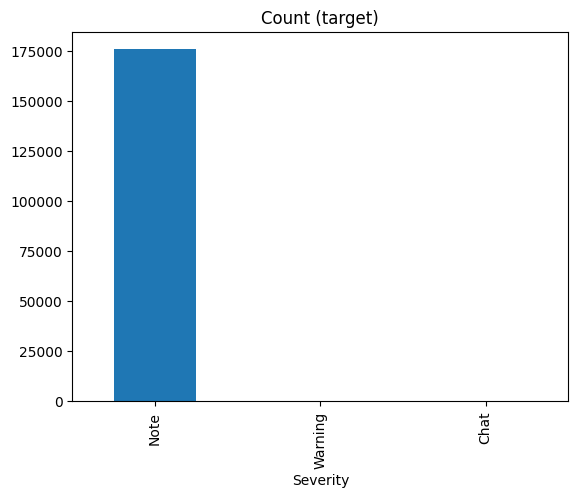

In [7]:
target_count = df['Severity'].value_counts()
print(target_count)

# Calculate proportions for a binary target class
proportion = target_count[1] / target_count[0]  # Calculate the proportion for the second class over the first
print('Proportion:', round(proportion, 2))

target_count.plot(kind='bar', title='Count (target)')

# Preprocessing

In [8]:
df.isnull().sum()

Time                                 0
Source                               0
Src Port                             0
Destination                          0
Dest. Port                           0
Protocol                             0
Length                               0
Differentiated Services Field        0
Flags                                0
TCP Options                        128
Severity                         77512
Info                                 0
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.Severity.unique()

array(['Warning', 'Note', 'Chat'], dtype=object)

In [11]:
df.Protocol.unique()

array(['TLSv1.2', 'TCP', 'HTTP', 'HTTP/JSON'], dtype=object)

In [12]:
df.drop(columns=['Time', 'Info'], inplace=True)

In [13]:
cols_to_encode = ['Source','Destination','Protocol','Differentiated Services Field','Flags','TCP Options','Severity']

encoder = LabelEncoder()

df_encoded = df

for feature in df:
    if feature in cols_to_encode:
        df_encoded[feature] = encoder.fit_transform(df[feature])

df_encoded

,Source,Src Port,Destination,Dest. Port,Protocol,Length,Differentiated Services Field,Flags,TCP Options,Severity
0,1,59620,4,443,3,64468,0,3,175620,2
1,1,59620,4,443,3,64468,0,3,175621,2
2,1,59620,4,443,3,64468,0,3,175621,2
3,1,59620,4,443,3,64468,0,3,175621,2
4,1,59620,4,443,3,64468,0,3,175622,2
...,...,...,...,...,...,...,...,...,...,...
253344,4,443,1,59620,2,96,1,1,175611,1
253345,4,443,1,59620,2,96,1,1,175612,1
253387,4,443,1,59620,2,80,1,1,175616,1
253388,4,443,1,59620,2,88,1,1,175617,1


In [14]:
scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_encoded)

# feature selection

In [15]:
df.isnull().any()

Source                           False
Src Port                         False
Destination                      False
Dest. Port                       False
Protocol                         False
Length                           False
Differentiated Services Field    False
Flags                            False
TCP Options                      False
Severity                         False
dtype: bool

In [16]:
X = df.drop(['Severity'], axis=1)
y = df['Severity']

In [17]:
# # Handle missing values
# imputer = SimpleImputer(strategy='mean')  # Choose the appropriate strategy
# X_imputed = imputer.fit_transform(X)

# SMOTE() for resolving imbalance

In [18]:
oversample = SMOTE()

X_sampled, y_sampled = oversample.fit_resample(X, y)

# splitting

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

In [20]:
clf = SGDClassifier()

clf.fit(X_train, y_train)

SGDClassifier()

In [21]:
y_pred = clf.predict(X_test)

In [22]:
acc_score = accuracy_score(y_test, y_pred)
clf_report = classification_report(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

print(f"Accuracy:\n{acc_score}\n\n{clf_report}\nConfusion matrix:\n{conf_mat}")

Accuracy:
0.929285449833395

              precision    recall  f1-score   support

           0       0.96      0.86      0.91     35056
           1       0.94      1.00      0.97     35104
           2       0.89      0.93      0.91     35179

    accuracy                           0.93    105339
   macro avg       0.93      0.93      0.93    105339
weighted avg       0.93      0.93      0.93    105339

Confusion matrix:
[[29973   873  4210]
 [    0 35104     0]
 [ 1112  1254 32813]]
